## Success Percentage


In [1]:
# Constants
medianColor = 'cyan'

In [2]:
import os
from pathlib import Path
import sys
path = Path(os.getcwd())

# need to include path to the root of this reprository
abspath = str(path.absolute().parent.parent / 'bci_plot')
sys.path.append(abspath)

In [3]:
figure_creation_param = {
    'HitRatePath':str(path.absolute().parent.parent / 'figs' / 'Hit Rate'),
    'SuccessPercentagePath':str(path.absolute().parent.parent / 'figs' / 'Success Percentage'),
}
Path(figure_creation_param['HitRatePath']).mkdir(parents=True, exist_ok=True)
Path(figure_creation_param['SuccessPercentagePath']).mkdir(parents=True, exist_ok=True)

In [4]:
from tools.data_util import load_data
from tools.ABA_bar_plot import plotABAmeanbar, plotABAbar
from tools.AB_box_plot import plotABboxfor4, plotABbox
from tools.iterate import get_copilot_session_names, get_copilot_session_by_ABA, get_trial_beginning_end, get_dial_in_time
from tools.plot import plotMeanStdBox
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import datetime
import yaml
import tqdm
import scipy

In [5]:
## all data in interest from exp tracker
copilotSessions = get_copilot_session_names()
copilotABASessions = get_copilot_session_by_ABA()

## Nicer bar plot according to mean Sucess Percentage by 4 subjects

In [6]:
# get time to touch
copilotABASessions = get_copilot_session_by_ABA()

HitCollection = {}
subjects = ['H1','H2','H4','S2']
ABAlabels = ['A1','B1','A2']
for s in subjects:
    HitCollection[s] = {}
    for label in ABAlabels:
        HitCollection[s][label] = ''

for i, ABAsession in tqdm.tqdm(enumerate(copilotABASessions)):
    sub = np.unravel_index(i, (4,4))
    HitRateABA = []
    for sessionName, label in zip(ABAsession,ABAlabels):
    # for sessionName, label in zip(ABAsession[1:],(f'{i}B',f'{i}A')):    

        dataPath = Path('/data/raspy')
        taskData = load_data(dataPath / sessionName / 'task.bin')
        beginEnd = get_trial_beginning_end(taskData)
        trialResult = ''.join([chr(taskData['game_state'][e].item()) for b,e in beginEnd])
        trialResult = trialResult[4:] # remove 4 calibration

        # add it to correct bin
        for subject in subjects:
            if subject in sessionName:
                HitCollection[subject][label] += trialResult

for s in subjects:
    for label in ABAlabels:
        trialResult = HitCollection[s][label]
        hitRate = trialResult.count('H') / len(trialResult) * 100
        HitCollection[s][label] = hitRate

    

0it [00:00, ?it/s]13it [00:01,  9.98it/s]


## Success Percentage

In [7]:
# get hit collection by box
copilotABASessions = get_copilot_session_by_ABA()

HitCollection = {}
subjects = ['H1','H2','H4','S2']
ABAlabels = ['A1','B1','A2']
for s in subjects:
    HitCollection[s] = {}
    for label in ABAlabels:
        HitCollection[s][label] = []

for i, ABAsession in tqdm.tqdm(enumerate(copilotABASessions)):
    sub = np.unravel_index(i, (4,4))
    HitRateABA = []
    for sessionName, label in zip(ABAsession,ABAlabels):
    # for sessionName, label in zip(ABAsession[1:],(f'{i}B',f'{i}A')):    

        dataPath = Path('/data/raspy')
        taskData = load_data(dataPath / sessionName / 'task.bin')
        beginEnd = get_trial_beginning_end(taskData)
        trialResult = ''.join([chr(taskData['game_state'][e].item()) for b,e in beginEnd])
        trialResult = trialResult[4:] # remove 4 calibration
        blockSize = 4
        hitCountByBlock = [(trialResult[i:i+blockSize].count('H') / blockSize) * 100 for i in range(0,len(trialResult),blockSize)]
            
        # add it to correct bin
        for subject in subjects:
            if subject in sessionName:
                HitCollection[subject][label] += hitCountByBlock

0it [00:00, ?it/s]13it [00:01,  9.54it/s]


In [8]:
# get hit collection by box for AB only with no duplication
HitCollectionNoDup = {}
subjectsWithHealthySCI = ['H1','H2','H4','S2','Healthy', 'SCI'] # just for this no dup
ABlabels = ['A','B']
for s in subjectsWithHealthySCI:
    HitCollectionNoDup[s] = {}
    for label in ABlabels:
        HitCollectionNoDup[s][label] = []

for sessionName, label in tqdm.tqdm(get_copilot_session_names(label=True)):
    # getSessionName, subject name, label
    subjectName = sessionName.split('_')[1]

    dataPath = Path('/data/raspy')
    taskData = load_data(dataPath / sessionName / 'task.bin')
    beginEnd = get_trial_beginning_end(taskData)
    trialResult = ''.join([chr(taskData['game_state'][e].item()) for b,e in beginEnd])
    trialResult = trialResult[4:] # remove 4 calibration
    hitRate = trialResult.count('H') / len(trialResult) * 100
    blockSize = 4
    hitCountByBlock = [(trialResult[i:i+blockSize].count('H') / blockSize) * 100 for i in range(0,len(trialResult),blockSize)]
         
    HitCollectionNoDup[subjectName][label] += hitCountByBlock

# Healthy & SCI
for label in ABlabels:
    for s in subjectsWithHealthySCI:
        if 'H' in s and len(s) == 2:
            HitCollectionNoDup['Healthy'][label] += HitCollectionNoDup[s][label]
        if 'S' in s and len(s) == 2:
            HitCollectionNoDup['SCI'][label] += HitCollectionNoDup[s][label]
        




  8%|▊         | 3/36 [00:00<00:01, 29.12it/s]100%|██████████| 36/36 [00:01<00:00, 28.36it/s]


### ABA box plot

### box plot AB

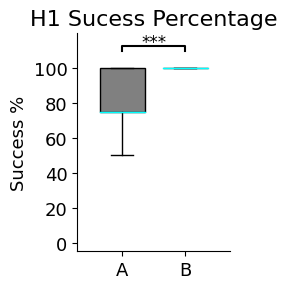

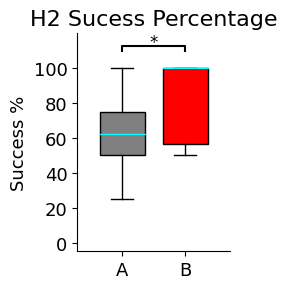

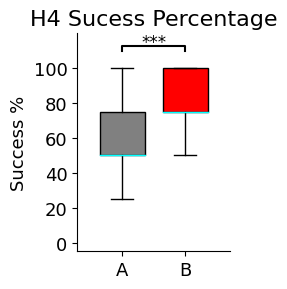

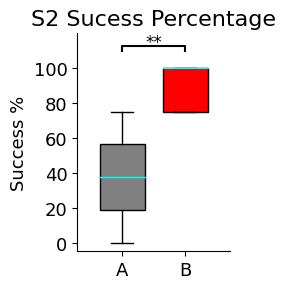

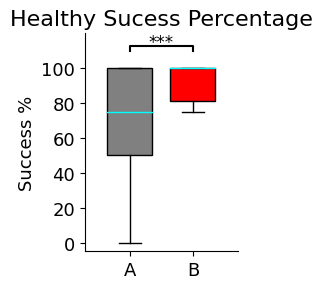

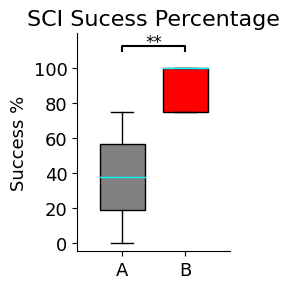

In [9]:
ylim = (0, 150)
useStar = True
useP = False

for subject in subjectsWithHealthySCI:
    labels = ['A', 'B']
    colors = ['grey', 'red']
    HitCollectionA = HitCollectionNoDup[subject]['A']
    HitCollectionB = HitCollectionNoDup[subject]['B']

    plotABbox(HitCollectionA, HitCollectionB, 
              title=f'{subject} Sucess Percentage',
              ylabel='Success %',
              ylim=(-5,120),
              manual_y_ticks=[0,20,40,60,80,100],
              medianColor=medianColor,
            #   useStar=True,
              savePath=f'{figure_creation_param["SuccessPercentagePath"]}/Success Percentage by block 4 AB box stars {subject}.pdf',
              useStar=True,
              useLegends=False,
              others = {
                'figsize':(2.5, 3),
                'barpos':[0,0.7],
                'ylabelFontSize':13,
              },
              )


### box plot AB for all 4 at once

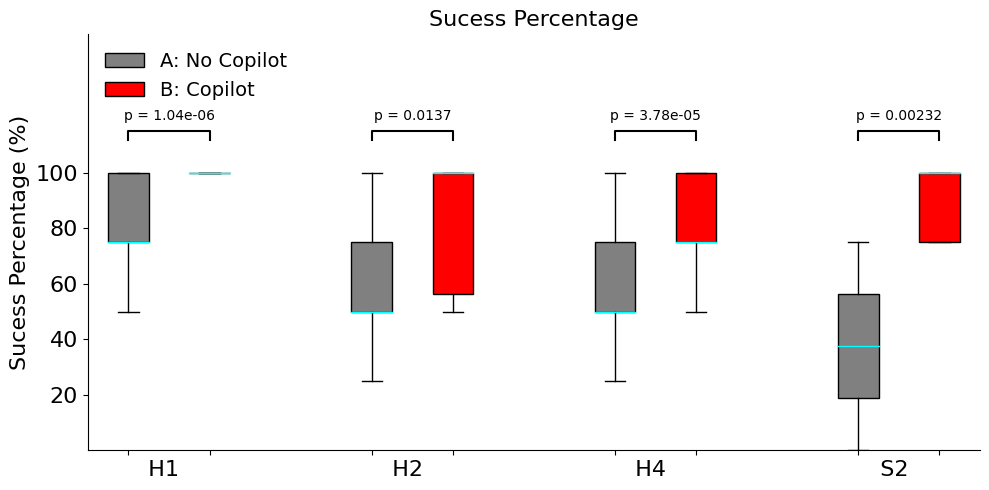

In [10]:
HitCollectionA = []
HitCollectionB = []
for subject in subjects:
    labels = ['A', 'B']
    colors = ['grey', 'red']
    HitCollectionA += [np.concatenate([HitCollection[subject]['A1'], HitCollection[subject]['A2']])]
    HitCollectionB += [HitCollection[subject]['B1']]

plotABboxfor4(HitCollectionA, HitCollectionB, 
              title='Sucess Percentage',
              ylabel='Sucess Percentage (%)',
              ylim=(0,150),
              manual_y_ticks=[20,40,60,80,100],
              medianColor=medianColor,
              #savePath=f'{figure_creation_param["SuccessPercentagePath"]}/Success Percentage by block 4 AB box pvalue all subjects (dup).pdf',
              useP=True)


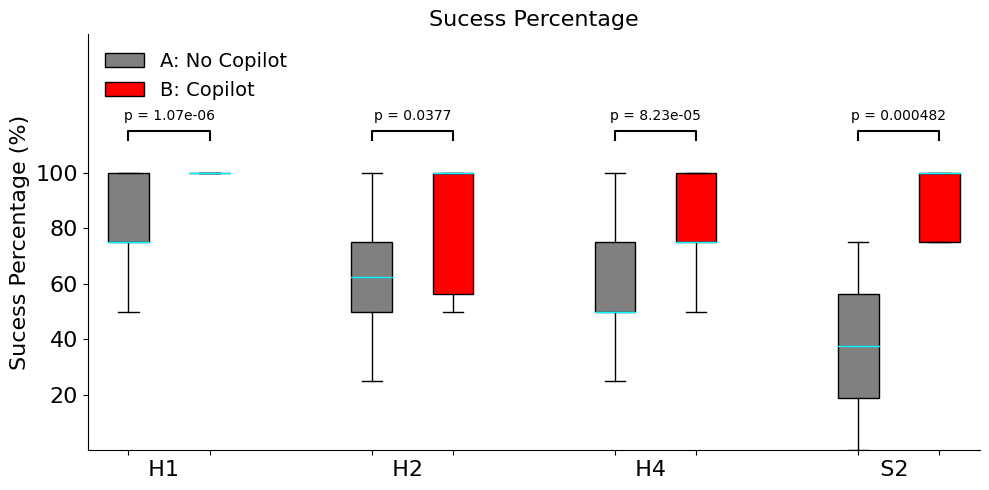

In [11]:
HitCollectionA = []
HitCollectionB = []
for subject in subjects:
    labels = ['A', 'B']
    colors = ['grey', 'red']
    HitCollectionA += [HitCollectionNoDup[subject]['A']]
    HitCollectionB += [HitCollectionNoDup[subject]['B']]

plotABboxfor4(HitCollectionA, HitCollectionB, 
              title='Sucess Percentage',
              ylabel='Sucess Percentage (%)',
              ylim=(0,150),
              manual_y_ticks=[20,40,60,80,100],
              medianColor=medianColor,
              #savePath=f'{figure_creation_param["SuccessPercentagePath"]}/Success Percentage by block 4 AB box pvalue all subjects.pdf',
              useP=True)


# ABA hit rate  
Hit rate = number of target acquired in seconds for out trial.   
calculated by block: 8 target

In [12]:
# get time to touch
copilotABASessions = get_copilot_session_by_ABA()

HitRateCollection = {}
subjects = ['H1','H2','H4','S2']
ABAlabels = ['A1','B1','A2']
for s in subjects:
    HitRateCollection[s] = {}
    for label in ABAlabels:
        HitRateCollection[s][label] = []

for i, ABAsession in tqdm.tqdm(enumerate(copilotABASessions)):
    sub = np.unravel_index(i, (4,4))
    HitRateABA = []
    for sessionName, label in zip(ABAsession,ABAlabels):
    # for sessionName, label in zip(ABAsession[1:],(f'{i}B',f'{i}A')):    

        dataPath = Path('/data/raspy')
        taskData = load_data(dataPath / sessionName / 'task.bin')
        beginEnd = get_trial_beginning_end(taskData)
        beginEnd = beginEnd[4:] # remove 4 calibration
        trialResult = ''.join([chr(taskData['game_state'][e].item()) for b,e in beginEnd])
        hitRateByBlock = []
        blockSize = 4
        for i in range(0, len(trialResult), blockSize):
            hit = trialResult[i:i+blockSize].count('H')
            durationNanoSeconds = sum([taskData['time_ns'][e]-taskData['time_ns'][b] for b,e in beginEnd[i:i+blockSize]])
            hitRateOfOneBlock = hit * 10**9 / durationNanoSeconds 
            hitRateByBlock.append(hitRateOfOneBlock)
        
        # add it to correct bin
        for subject in subjects:
            if subject in sessionName:
                HitRateCollection[subject][label] += hitRateByBlock

0it [00:00, ?it/s]13it [00:01,  9.33it/s]


In [13]:
# get hit collection by box for AB only with no duplication
HitRateCollectionNoDup = {}
subjectsWithHealthySCI = ['H1','H2','H4','S2', 'Healthy', 'SCI'] # just for this no dup
ABlabels = ['A','B']
for s in subjectsWithHealthySCI:
    HitRateCollectionNoDup[s] = {}
    for label in ABlabels:
        HitRateCollectionNoDup[s][label] = []

for sessionName, label in tqdm.tqdm(get_copilot_session_names(label=True)):
    print(sessionName)
    # getSessionName, subject name, label
    subjectName = sessionName.split('_')[1]

    dataPath = Path('/data/raspy')
    taskData = load_data(dataPath / sessionName / 'task.bin')
    beginEnd = get_trial_beginning_end(taskData)
    beginEnd = beginEnd[4:] # remove 4 calibration
    trialResult = ''.join([chr(taskData['game_state'][e].item()) for b,e in beginEnd])
    hitRateByBlock = []
    blockSize = 4
    for i in range(0, len(trialResult), blockSize):
        hit = trialResult[i:i+blockSize].count('H')
        durationNanoSeconds = sum([taskData['time_ns'][e]-taskData['time_ns'][b] for b,e in beginEnd[i:i+blockSize]])
        hitRateOfOneBlock = hit * 10**9 / durationNanoSeconds 
        hitRateByBlock.append(hitRateOfOneBlock)
        
    HitRateCollectionNoDup[subjectName][label] += hitRateByBlock

# Healthy & SCI
for label in ABlabels:
    for s in subjectsWithHealthySCI:
        if 'H' in s and len(s) == 2:
            HitRateCollectionNoDup['Healthy'][label] += HitRateCollectionNoDup[s][label]
        if 'S' in s and len(s) == 2:
            HitRateCollectionNoDup['SCI'][label] += HitRateCollectionNoDup[s][label]

  8%|▊         | 3/36 [00:00<00:01, 28.94it/s]

2024-02-14_H1_CL_CP_1
2024-02-14_H1_CL_CP_2
2024-02-14_H1_CL_CP_3
2024-02-14_H1_CL_CP_5
2024-02-14_H1_CL_CP_6
2024-02-14_H1_CL_CP_7
2024-02-15_H1_CL_5


 31%|███       | 11/36 [00:00<00:00, 29.82it/s]

2024-02-15_H1_CL_6
2024-02-15_H1_CL_7
2024-02-15_H1_CL_8
2024-02-15_H1_CL_9
2024-02-15_H1_CL_10
2024-02-20_H1_CL_5


 50%|█████     | 18/36 [00:00<00:00, 29.36it/s]

2024-02-20_H1_CL_6
2024-02-20_H1_CL_7
2024-02-20_H1_CL_8
2024-02-16_H2_CL_2
2024-02-16_H2_CL_3
2024-02-16_H2_CL_4


 67%|██████▋   | 24/36 [00:00<00:00, 28.38it/s]

2024-02-16_H2_CL_6
2024-02-16_H2_CL_7
2024-03-18_S2_CL_3
2024-03-18_S2_CL_4
2024-03-18_S2_CL_5
2024-03-18_S2_CL_6


 75%|███████▌  | 27/36 [00:00<00:00, 27.94it/s]

2024-03-01_H4_CL_4
2024-03-01_H4_CL_5
2024-03-01_H4_CL_6
2024-03-04_H4_CL_5
2024-03-04_H4_CL_6


 92%|█████████▏| 33/36 [00:01<00:00, 25.79it/s]

2024-03-04_H4_CL_7
2024-03-04_H4_CL_8
2024-03-04_H4_CL_9
2024-03-11_H4_CL_5
2024-03-11_H4_CL_6
2024-03-11_H4_CL_7


100%|██████████| 36/36 [00:01<00:00, 27.66it/s]


### ABA hit rate Box plot

### box plot hit rate AB

H1 A median 3.705667800048764
H1 B median 7.835927142105457
H2 A median 2.0558708910732224
H2 B median 4.3985192123526105
H4 A median 2.112427092517466
H4 B median 4.30143462739081
S2 A median 1.0441633492927975
S2 B median 4.522575241217609
Healthy A median 2.954803615147676
Healthy B median 6.677978845367672
SCI A median 1.0441633492927975
SCI B median 4.522575241217609


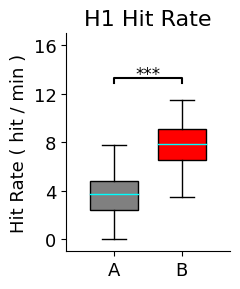

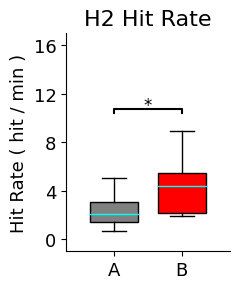

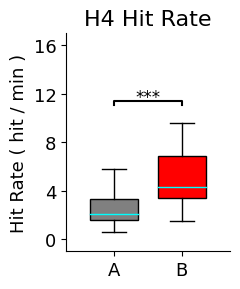

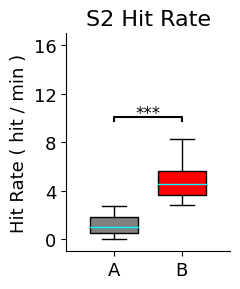

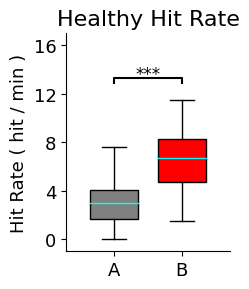

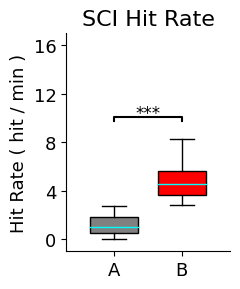

In [14]:
ylim = (0, 150)
useStar = True
useP = False

for subject in subjectsWithHealthySCI:
    labels = ['A', 'B']
    colors = ['grey', 'red']
    HitRateCollectionA = np.array(HitRateCollectionNoDup[subject]['A']) * 60
    HitRateCollectionB = np.array(HitRateCollectionNoDup[subject]['B']) * 60

    print(subject, 'A median', np.median(HitRateCollectionA))
    print(subject, 'B median', np.median(HitRateCollectionB))

    plotABbox(HitRateCollectionA, HitRateCollectionB, 
              title=f'{subject} Hit Rate',
              ylabel='Hit Rate ( hit / min )',
              ylim=(-1, 0.3 * 60-1),
              manual_y_ticks=[0,4,8,12,16],
              medianColor=medianColor,
            #   useStar=True,
              savePath=f'{figure_creation_param["HitRatePath"]}/Hit Rate by block 4 AB box stars {subject}.pdf',
              useStar=True,
              useLegends=False,
              others = {
                'figsize':(2.5, 3),
                'barpos':[0,0.7],
                'ylabelFontSize':13,
              })


### box plot hit rate AB for all 4 at once

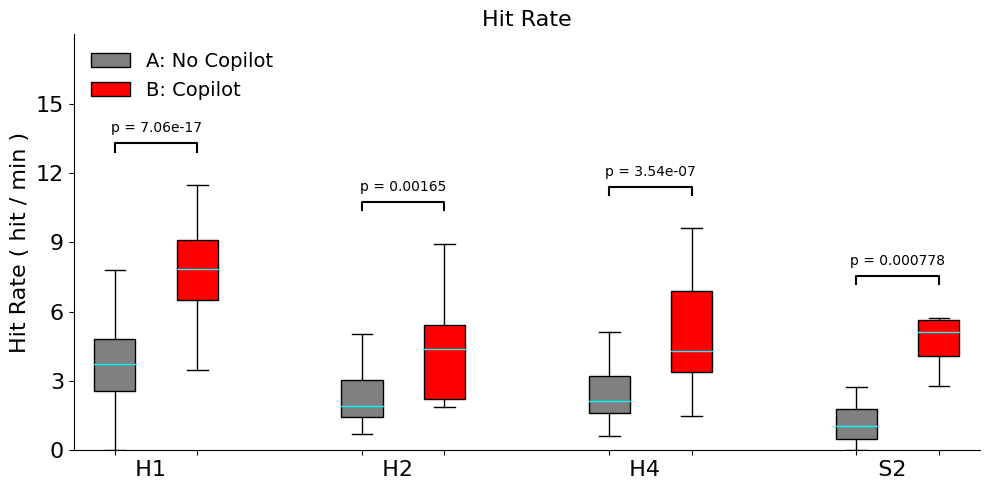

In [15]:
HitRateCollectionA = []
HitRateCollectionB = []
for subject in subjects:
    labels = ['A', 'B']
    colors = ['grey', 'red']
    HitRateCollectionA += [np.concatenate([HitRateCollection[subject]['A1'], HitRateCollection[subject]['A2']])*60]
    HitRateCollectionB += [np.array(HitRateCollection[subject]['B1'])*60]

plotABboxfor4(HitRateCollectionA, HitRateCollectionB, 
              title='Hit Rate',
              ylabel='Hit Rate ( hit / min )',
              ylim=(0, 0.3 * 60),
              manual_y_ticks=[0,3,6,9,12,15],
              medianColor=medianColor,
              #savePath=f'{figure_creation_param["HitRatePath"]}/Hit Rate by block 4 AB box pvalue all subjects (dup).pdf',
              useP=True)


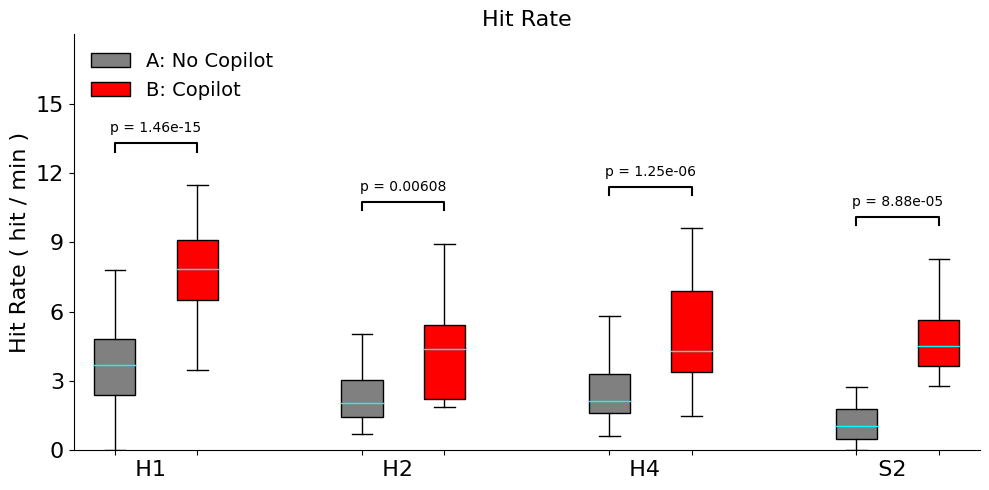

In [16]:
HitRateCollectionA = []
HitRateCollectionB = []
for subject in subjects:
    labels = ['A', 'B']
    colors = ['grey', 'red']
    HitRateCollectionA += [np.array(HitRateCollectionNoDup[subject]['A'])*60]
    HitRateCollectionB += [np.array(HitRateCollectionNoDup[subject]['B'])*60]

plotABboxfor4(HitRateCollectionA, HitRateCollectionB, 
              title='Hit Rate',
              ylabel='Hit Rate ( hit / min )',
              ylim=(0, 0.3 * 60),
              manual_y_ticks=[0,3,6,9,12,15],
              medianColor=medianColor,
              #savePath=f'{figure_creation_param["HitRatePath"]}/Hit Rate by block 4 AB box pvalue all subjects.pdf',
              useP=True)
